# Linear and Non Linear models

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import seaborn as sns
import sys
sys.path.insert(0, "../..")

## 1 Linear models
One of the simplest models is the linear model. The basic shape of the formula is:

$$
y = wx + b
$$
Here, $x$ is a variable, $w$ and $b$ are constants that determine the slope and intercept of the line.

We can scale this formula for multiple variables, like this:
$$
y = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b
$$

Because it is easier to do this calculation as a dotproduct, we will typically use matrices.

So, let us have $n$ observations of $m$ features, and we will represent that in a matrix $X$ with dimensions $(n,m)$. We will generate random observations:

In [2]:
n = 100
m = 3
X = torch.rand(n, m)
X.shape

torch.Size([100, 3])

This matrix $X$ is our data. Now we want to have $m$ weights, and we want to sum that up untill we have a single number, so our weight $W$ will have dimensions $(m, 1)$. To get matrix multiplication to work, we need the last dimension of $X$ and the first dimension of $W$ to match. So because $X$ has 3 features (last dimension of $X$)$ our $W$ needs to have 3 numbers as its first dimension for `jnp.dot(X, W)` to work.

In [3]:
W = torch.normal(0., 0.1, (m, 1))
b = torch.normal(0, 0.1, (1,))
W, b

(tensor([[-0.0176],
         [ 0.1666],
         [ 0.0600]]),
 tensor([0.0654]))

In [4]:
W.shape, b.shape

(torch.Size([3, 1]), torch.Size([1]))

Instead of using a forloop to calculate this linear formula $n$ times, we will use a dotproduct. This will calcute 

$$ 
y = w_1 x_1 + w_2 x_2 + w_3 x_3 + b
$$

for all $n$ observations.

In [5]:
yhat = torch.matmul(X, W) + b
yhat.shape

torch.Size([100, 1])

All we have to do is to learn the right weights, and we have a linear model. 
We could easily generate a 2 dimensional output instead of a 1 dimensional output by increasing the dimension of $W$

In [6]:
W = torch.normal(0., 0.1, (m, 2))
yhat = torch.matmul(X, W)
yhat.shape

torch.Size([100, 2])

## 2 Non linear models
However, the simplicity of linear models is both their strength and weakness:
- The simplicity protects against overfitting
- The simplicity will underfit on non-linear datasets

While a lot of things can be approached as a linear model, there are often more complex and non-linear relations in datasets. A naive idea could be to chain multiple linear models together, like this:

$$
y = f_2(f_1(x))
$$

which is equal to:

$$
y = W_2 (W_1 X + b_1) + b_2
$$

The idea is simply to feed the output of one model to the next. However, the problem here will be that you will end up with something that is equal to a single linear model:

\begin{align}
y &= W_2 W_1 X + W_2 b_1 + b_2\\
y &= W_3 X + b_3\\
\end{align}

If you simplify $W_2 W_1$ to $W_3$ and $W_2 b_1 + b_2$ to $b_3$. 

## 3 Activation functions
However, what will work for chaining is to add an activation function. There are a lot of functions that will work as an activation function; the main requirement is that they are non-linear.

In [7]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

<AxesSubplot:>

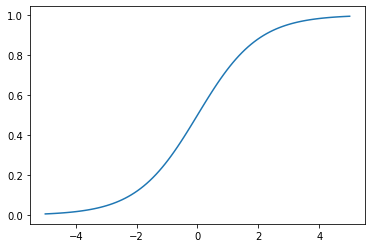

In [8]:
k = 100
x = torch.linspace(-5,5, k)
sns.lineplot(x=x, y=sigmoid(x))

Intuitively, you can understand an activation function as a threshold. For example, the sensation of your chair usually lies below the threshold for noticing the sensation. If you increase the input (on the x-axis) you will get above the threshold as output (on the y-axis) at some point.  

There are many types of activation functions. The simplest one is the ReLu, which is 0 if $x \le 0$ and the identity function otherwise.

<AxesSubplot:>

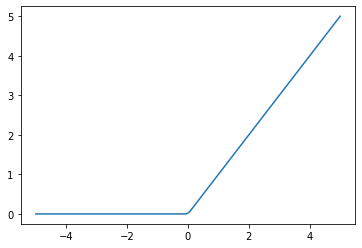

In [9]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.Tensor([0.]), x)

sns.lineplot(x=x, y=relu(x))

This gives us all the building blocks needed for a neural network:

![neural net](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1547672259/2_i1cdwq.png)

Here, every observation has $n$ features, in this case three.
Every input has a corresponding weight $w$, which is summed up with a linear model. 
The output of the linear model is the fed through an activation function.

Let's test that. First we will generate Tuples $(W, b)$. We will make sure the dimensions of output and input will match.

In [10]:
from src.models import build
W,b = build.init_weights(10, 2)
W.shape, b.shape

(torch.Size([10, 2]), torch.Size([2]))

In [26]:

layersizes = [2, 8, 2, 1]
params = build.torch_network(layersizes)
for w,_ in params:
    print(w.shape)

torch.Size([2, 8])
torch.Size([8, 2])
torch.Size([2, 1])


In [27]:
for w,b in params:
    print(w, "\n")
    print(b, "\n")

tensor([[ 0.0106,  0.0114, -0.0036, -0.0211,  0.0140,  0.0118, -0.0067,  0.0055],
        [ 0.0040, -0.0094,  0.0164,  0.0199,  0.0088,  0.0230,  0.0021, -0.0156]]) 

tensor([ 0.0075, -0.0002,  0.0005,  0.0141,  0.0193, -0.0023,  0.0038, -0.0030]) 

tensor([[-0.0058,  0.0072],
        [ 0.0039, -0.0136],
        [-0.0089, -0.0050],
        [-0.0102,  0.0128],
        [-0.0102,  0.0036],
        [-0.0114, -0.0020],
        [-0.0022,  0.0004],
        [-0.0072, -0.0166]]) 

tensor([0.0061, 0.0088]) 

tensor([[ 0.0170],
        [-0.0075]]) 

tensor([0.0008]) 



We have three matrices. The first receives 2 features as input, 8 as output with dimensions $(2,8)$, the second will receive these 8 features as input, 2 as output and thus has $(8,2)$ dimensions, and the final layer transforms 2 dimensions into 1.

This would similar to $f_1(f_2(f_3(x)))$, so chaining 3 models. However, because chaining linear models adds nothing, this could be reduced to $f(x)$ where $f$ is a linear model.

Let's visualize this. First, I will build a 2D grid on the domain $[0,1]$ with a granularity of 100, so I will have $100*100$ coordinates.

In [28]:
from src.data import make_dataset
k = 100
grid, x, y = make_dataset.build_grid(k=k)

In [29]:
grid = torch.from_numpy(grid).type(torch.float32)

In [30]:
W, b = params[0]
W.dtype

torch.float32

In [31]:
from src.models import linear

out = linear.predict(params, grid)
z = out.reshape(k,k)

import plotly.graph_objects as go
fig = go.Figure(data=go.Surface(x=x, y=y, z=z))
fig.show()


2022-02-16 14:01:01.839 | INFO     | src.models.linear:predict:13 - Shape: torch.Size([10000, 8])
2022-02-16 14:01:01.841 | INFO     | src.models.linear:predict:13 - Shape: torch.Size([10000, 2])
2022-02-16 14:01:01.843 | INFO     | src.models.linear:predict:13 - Shape: torch.Size([10000, 1])


Exactly what we expected. We have a 2D hyperplane. If we are doing classification, this hyperplane splits the 3D datapoints into two classes, and we could classify the group of point that fall above or below the hyperplane as belonging to one or another class.

In the case of regression, we would want the point to fall on the hyperplane, as much as possible.

Even though we could scale this to more dimensions easily, the limitations of a linear model should be clear: a lot of data simply is not linear.

To avoid this, we can add tricks to our model:

- a simple approach would be to do basis expansion. E.g. points $X = (x_1, x_2)$ might not be linear serparable, but $\phi(X) = (x_1, x_2, x_1 x_2, x_1^2, x_2^2)$ is a basis expansion that might be linear.
- because basis expansion runs into scaling problems pretty fast (it scales roughly $O(n^2)$) we could use the kernel trick, like a Support Vector Machine does. 
- We could use a decision tree or randomm model, which is a way to chain linear models that result in non linear models) we could use the kernel trick, like a Support Vector Machine does. 
- We could use a decision tree or randomm model, which is a way to chain linear models that result in non linear models.

These "tricks" cover most of the classic models you can find in the scikit-learn library. While they have advantages, there will still be cases where these models are not commplex enough. 

# Neural Networks
A neural network chains linear models with an activation function. The only thing that is different in the next model is that after every linear transformation we will apply the relu function.

![full network](../../reports/figures/nnet.png)

This is what a fully connected neural network would look like.
We can recognize the single units with the multiple inputs.

Rebuild the parameters a few times and see how the model changes.

In [41]:
layersizes = [2, 8, 2, 1]
params = build.torch_network(layersizes, scale=1e-1)

In [42]:
out = linear.nn_predict(params, grid)
z = out.reshape(k,k)
fig = go.Figure(data=go.Surface(x=x, y=y, z=z))
fig.show()

2022-02-16 14:04:09.664 | INFO     | src.models.linear:nn_predict:26 - Shape: torch.Size([10000, 8])
2022-02-16 14:04:09.670 | INFO     | src.models.linear:nn_predict:26 - Shape: torch.Size([10000, 2])
2022-02-16 14:04:09.674 | INFO     | src.models.linear:nn_predict:31 - Shape: torch.Size([10000, 1])


Et voila! We have a non-linear model. We will need to add a learning process, so that the model can learn to adjust its weights in order to fit the training data, but this is the basics of a neural network.